In [183]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torchvision.transforms import v2
from torch.utils.data import Dataset, DataLoader
import os
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from downsampling import bicubic_interpolation
from einops.layers.torch import Rearrange

In [184]:
mean,std=[0,0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0,0]
mean_context,std_context=[0,0],[0,0]
datasize=len(os.listdir('C:/Users/moham/OneDrive/Bureau/summer_internship/data/grp2'))
for dir in os.listdir('C:/Users/moham/OneDrive/Bureau/summer_internship/data/grp2'):
    dataset=rasterio.open(os.path.join("C:/Users/moham/OneDrive/Bureau/summer_internship/data/grp2",dir,(os.listdir(os.path.join("C:/Users/moham/OneDrive/Bureau/summer_internship/data/grp2",dir))[0])))
    image=dataset.read()
    for i in range(10):
        mean[i]=mean[i]+np.mean(image[i])
        std[i]=std[i]+np.std(image[i])
    a=torch.load(os.path.join("C:/Users/moham/OneDrive/Bureau/summer_internship/data/grp2",dir,(os.listdir(os.path.join("C:/Users/moham/OneDrive/Bureau/summer_internship/data/grp2",dir))[1])))
    for i in range(2):
        mean_context[i]=mean_context[i]+torch.mean(a[i])
        std_context[i]=std_context[i]+torch.std(a[i])
for i in range(10):
    mean[i]=mean[i]/datasize
    std[i]=std[i]/datasize
for i in range(2):
    mean_context[i]=mean_context[i]/datasize
    std_context[i]=std_context[i]/datasize
transforms = v2.Compose([v2.Normalize(mean, std),v2.Lambda(lambda t: (t * 2) - 1),v2.ToDtype(torch.float32)])
tranforms_context=v2.Compose([v2.Normalize(mean_context, std_context),v2.Lambda(lambda t: (t * 2) - 1)])

In [185]:
class CustomDataset(Dataset):
     
    def __init__(self, img_dir, transform=None,transforms_context=None):
        self.img_dir = img_dir
        self.transform = transform
        self.transforms_context = transforms_context
    def __len__(self):
        return len(os.listdir(self.img_dir))
        
    def __getitem__(self,idx):
        img_path = os.path.join(self.img_dir,os.listdir(self.img_dir)[idx])
        context_path = os.path.join(img_path,os.listdir(img_path)[1])
        img_path=os.path.join(img_path,os.listdir(img_path)[0])
        
        dataset=rasterio.open(img_path)
        image=dataset.read()
        tensr=(np.zeros((10,16,28)))
        for i in range(10):
            tensr[i][0:15,0:27]=bicubic_interpolation(image[i]).astype(np.int16)
        tensr=torch.tensor(tensr)
        patch=torch.load(context_path)        
        if self.transform:    
            tensr = self.transform(tensr)
        if self.transforms_context:
            patch=self.transforms_context(patch)
        return (tensr ,patch )

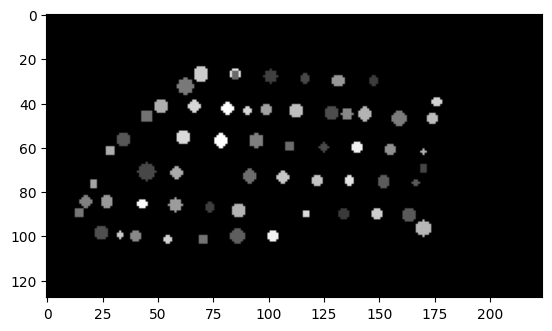

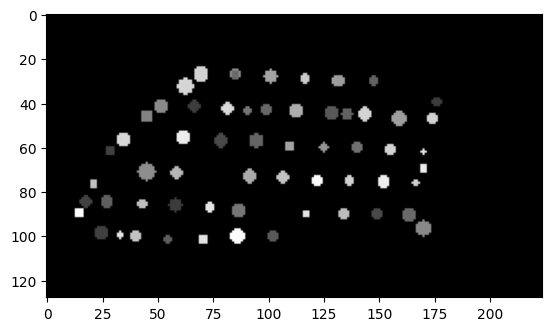

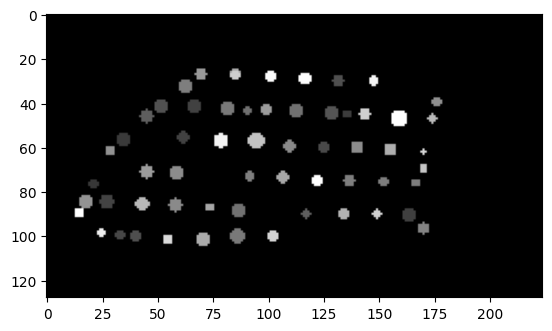

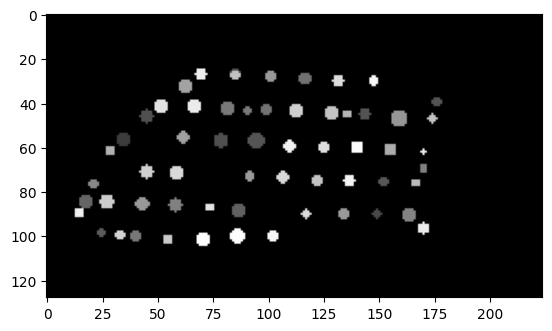

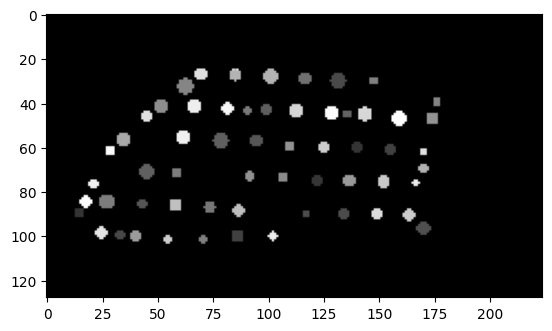

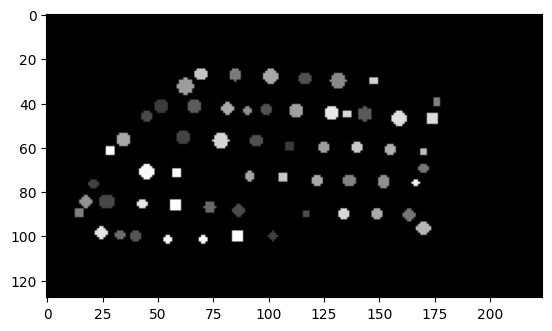

In [186]:
img_dir="C:/Users/moham/OneDrive/Bureau/summer_internship/data/grp2/"
IMG_height,IMG_width = 16,28
IMG_CH = 10
BATCH_SIZE = 28
data = CustomDataset(img_dir,transforms)
dataloader = DataLoader(data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
d=(data[0],data[1],data[2])

for i,k in d:
    plt.imshow(k[1],cmap='gray')
    plt.show()
    plt.imshow(k[0],cmap='gray')
    plt.show()
    for j in range(10):
        plt.imshow((i[j]),cmap='gray')
        plt.show()


In [187]:
nrows = 15
ncols = 15

T = nrows * ncols
start = 0.0001
end = 0.02
B = torch.linspace(start, end, T).to(device)
a = 1. - B
a_bar = torch.cumprod(a, dim=0)
sqrt_a_bar = torch.sqrt(a_bar)  # Mean Coefficient
sqrt_one_minus_a_bar = torch.sqrt(1 - a_bar) # St. Dev. Coefficient

In [188]:
def q(x_0, t):
    """
    Samples a new image from q
    Returns the noise applied to an image at timestep t
    x_0: the original image
    t: timestep
    """
    t = t.int()
    noise = torch.randn_like(x_0)
    sqrt_a_bar_t = sqrt_a_bar[t, None, None, None]
    sqrt_one_minus_a_bar_t = sqrt_one_minus_a_bar[t, None, None, None]
    x_t = sqrt_a_bar_t * x_0 + sqrt_one_minus_a_bar_t * noise
    return x_t, noise

In [189]:
"""plt.figure(figsize=(28, 28))
x_0 = data[0][0].to(device)  # Initial image
x_t = x_0
xs = []
for t in range(T):
    t_tenser = torch.Tensor([t]).type(torch.int64)
    x_t, _ = q(x_0, t_tenser)
    img = torch.squeeze(x_t).cpu()
    xs.append(img)
    ax = plt.subplot(20, 30, t + 1)
    ax.axis('off')
    #other_utils.show_tensor_image(x_t)
    plt.imshow(img)
plt.savefig("forward_diffusion_skip.png", bbox_inches='tight')"""


'plt.figure(figsize=(28, 28))\nx_0 = data[0][0].to(device)  # Initial image\nx_t = x_0\nxs = []\nfor t in range(T):\n    t_tenser = torch.Tensor([t]).type(torch.int64)\n    x_t, _ = q(x_0, t_tenser)\n    img = torch.squeeze(x_t).cpu()\n    xs.append(img)\n    ax = plt.subplot(20, 30, t + 1)\n    ax.axis(\'off\')\n    #other_utils.show_tensor_image(x_t)\n    plt.imshow(img)\nplt.savefig("forward_diffusion_skip.png", bbox_inches=\'tight\')'

In [190]:
class GELUConvBlock(nn.Module):
    def __init__(
        self, in_ch, out_ch, group_size):
        super().__init__()
        layers = [
            nn.Conv2d(in_ch, out_ch, 3, 1, 1),
            nn.GroupNorm(group_size, out_ch),
            nn.GELU()
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [191]:
class RearrangePoolBlock(nn.Module):
    def __init__(self, in_chs, group_size):
        super().__init__()
        self.rearrange = Rearrange("b c (h p1) (w p2) -> b (c p1 p2) h w", p1=2, p2=2)
        self.conv = GELUConvBlock(4 * in_chs, in_chs, group_size)

    def forward(self, x):
        x = self.rearrange(x)
        return self.conv(x)

class EmbedBlock(nn.Module):
    def __init__(self, input_dim, emb_dim):
        super().__init__()
        self.input_dim = input_dim
        layers = [
            nn.Linear(input_dim, emb_dim),
            nn.ReLU(),
            nn.Linear(emb_dim, emb_dim),
            nn.Unflatten(1, (emb_dim, 1, 1))
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, input):
        input = input.view(-1, self.input_dim)
        return self.model(input)

In [192]:
class EmbedBlock(nn.Module):
    def __init__(self, input_dim, emb_dim):
        super(EmbedBlock, self).__init__()
        self.input_dim = input_dim
        layers = [
            nn.Linear(input_dim, emb_dim),
            nn.GELU(),
            nn.Linear(emb_dim, emb_dim),
            nn.Unflatten(1, (emb_dim, 1, 1))
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(-1, self.input_dim)
        return self.model(x)

class DownBlock(nn.Module):
    def __init__(self, in_chs, out_chs):
        kernel_size = 3
        stride = 1
        padding = 1

        super().__init__()
        layers = [
            nn.Conv2d(in_chs, out_chs, kernel_size, stride, padding),
            nn.BatchNorm2d(out_chs),
            nn.ReLU(),
            nn.Conv2d(out_chs, out_chs, kernel_size, stride, padding),
            nn.BatchNorm2d(out_chs),
            nn.ReLU(),
            nn.MaxPool2d(2)
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [193]:
class DownBlock(nn.Module):
    def __init__(self, in_chs, out_chs, group_size):
        super(DownBlock, self).__init__()
        layers = [
            GELUConvBlock(in_chs, out_chs, group_size),
            GELUConvBlock(out_chs, out_chs, group_size),
            RearrangePoolBlock(out_chs, group_size)
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

class UpBlock(nn.Module):
    def __init__(self, in_chs, out_chs):
        # Convolution variables
        kernel_size = 3
        stride = 1
        padding = 1

        # Transpose variables
        strideT = 2
        out_paddingT = 1

        super().__init__()
        # 2 * in_chs for concatenated skip connection
        layers = [
            nn.ConvTranspose2d(2 * in_chs, out_chs, kernel_size, strideT, padding, out_paddingT),
            nn.BatchNorm2d(out_chs),
            nn.ReLU(),
            nn.Conv2d(out_chs, out_chs, kernel_size, stride, padding),
            nn.BatchNorm2d(out_chs),
            nn.ReLU()
        ]
        self.model = nn.Sequential(*layers)
    
    def forward(self, x, skip):
        x = torch.cat((x, skip), 1)
        x = self.model(x)
        return x

In [194]:
class UpBlock(nn.Module):
    def __init__(self, in_chs, out_chs, group_size):
        super(UpBlock, self).__init__()
        layers = [
            nn.ConvTranspose2d(2 * in_chs, out_chs, 2, 2),
            GELUConvBlock(out_chs, out_chs, group_size),
            GELUConvBlock(out_chs, out_chs, group_size),
            GELUConvBlock(out_chs, out_chs, group_size),
            GELUConvBlock(out_chs, out_chs, group_size)
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x, skip):
        x = torch.cat((x,skip),1)
        x = self.model(x)
        return x

class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        img_chs = IMG_CH
        down_chs = (40, 80, 160)
        up_chs = down_chs[::-1]  # Reverse of the down channels
        latent_image_size = IMG_SIZE // 4 # 2 ** (len(down_chs) - 1)
        t_dim = 1 # New

        # Inital convolution
        self.down0 = nn.Sequential(
            nn.Conv2d(img_chs, down_chs[0], 3, padding=1),
            nn.BatchNorm2d(down_chs[0]),
            nn.ReLU()
        )

        # Downsample
        self.down1 = DownBlock(down_chs[0], down_chs[1])
        self.down2 = DownBlock(down_chs[1], down_chs[2])
        self.to_vec = nn.Sequential(nn.Flatten(), nn.ReLU())
        
        # Embeddings
        self.dense_emb = nn.Sequential(
            nn.Linear(down_chs[2]*latent_image_size**2, down_chs[1]),
            nn.ReLU(),
            nn.Linear(down_chs[1], down_chs[1]),
            nn.ReLU(),
            nn.Linear(down_chs[1], down_chs[2]*latent_image_size**2),
            nn.ReLU()
        )
        self.temb_1 = EmbedBlock(t_dim, up_chs[0])  # New
        self.temb_2 = EmbedBlock(t_dim, up_chs[1])  # New
        
        # Upsample
        self.up0 = nn.Sequential(
            nn.Unflatten(1, (up_chs[0], latent_image_size, latent_image_size)),
            nn.Conv2d(up_chs[0], up_chs[0], 3, padding=1),
            nn.BatchNorm2d(up_chs[0]),
            nn.ReLU(),
        )
        self.up1 = UpBlock(up_chs[0], up_chs[1])
        self.up2 = UpBlock(up_chs[1], up_chs[2])

        # Match output channels
        self.out = nn.Sequential(
            nn.Conv2d(up_chs[-1], up_chs[-1], 3, 1, 1),
            nn.BatchNorm2d(up_chs[-1]),
            nn.ReLU(),
            nn.Conv2d(up_chs[-1], img_chs, 3, 1, 1)
        )

    def forward(self, x, t):
        down0 = self.down0(x)
        down1 = self.down1(down0)
        down2 = self.down2(down1)
        latent_vec = self.to_vec(down2)
        
        # New
        t = t.float() / T  # Convert from [0, T] to [0, 1]
        latent_vec = self.dense_emb(latent_vec)
        temb_1 = self.temb_1(t)
        temb_2 = self.temb_2(t)

        up0 = self.up0(latent_vec)
        up1 = self.up1(up0+temb_1, down2)
        up2 = self.up2(up1+temb_2, down1)
        return self.out(up2)

In [195]:
import math

class SinusoidalPositionEmbedBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

In [196]:
class ResidualConvBlock(nn.Module):
    def __init__(self, in_chs, out_chs, group_size):
        super().__init__()
        self.conv1 = GELUConvBlock(in_chs, out_chs, group_size)
        self.conv2 = GELUConvBlock(out_chs, out_chs, group_size)

    def forward(self, x):
        x1 = self.conv1(x)
        x2 = self.conv2(x1)
        out = x1 + x2
        return out

In [197]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        img_chs = IMG_CH
        down_chs = (160, 160, 320)
        up_chs = down_chs[::-1]  # Reverse of the down channels
        latent_image_height = IMG_height // 4 # 2 ** (len(down_chs) - 1)
        latent_image_width = IMG_width // 4
        t_dim = 8
        group_size_base = 5
        small_group_size = 2 * group_size_base # New
        big_group_size = 8 * group_size_base  # New
        
        #context formatting
        self.format0=nn.Sequential(
            nn.Conv2d(2,10, 3, 1, 1),
            nn.BatchNorm2d(10),
            nn.GELU(),
            nn.MaxPool2d(2),
            nn.Conv2d(10,20, 3, 1, 1),
            nn.BatchNorm2d(20),
            nn.GELU(),
            nn.MaxPool2d(2),
            nn.Conv2d(20,40, 3, 1, 1),
            nn.BatchNorm2d(40),
            nn.GELU(),
            nn.MaxPool2d(2),
        )
        self.format1=nn.Sequential(
            GELUConvBlock(40, down_chs[-2], 2),
            GELUConvBlock(down_chs[-2], down_chs[-2], 2),
            RearrangePoolBlock(down_chs[-2], 2)
        )
        self.format2=nn.Sequential(
            GELUConvBlock(down_chs[-2], down_chs[-1], 2),
            GELUConvBlock(down_chs[-1], down_chs[-1], 2),
            RearrangePoolBlock(down_chs[-1], 2)
        )
        
        # Inital convolution
        self.down0 = ResidualConvBlock(img_chs, down_chs[0], small_group_size) # New

        # Downsample
        self.down1 = DownBlock(down_chs[0], down_chs[1], big_group_size) # New
        self.down2 = DownBlock(down_chs[1], down_chs[2], big_group_size) # New
        self.to_vec = nn.Sequential(nn.Flatten(), nn.GELU())
        
        # Embeddings
        self.dense_emb = nn.Sequential(
            nn.Linear(down_chs[2]*latent_image_height*latent_image_width,down_chs[1]),
            nn.ReLU(),
            nn.Linear(down_chs[1], down_chs[1]),
            nn.ReLU(),
            nn.Linear(down_chs[1], down_chs[2]*latent_image_height*latent_image_width),
            nn.ReLU()
        )

        self.sinusoidaltime = SinusoidalPositionEmbedBlock(t_dim) # New
        self.temb_1 = EmbedBlock(t_dim, up_chs[0])
        self.temb_2 = EmbedBlock(t_dim, up_chs[1])
        
        # Upsample
        self.up0 = nn.Sequential(
            nn.Unflatten(1, (up_chs[0], latent_image_height, latent_image_width)),
            GELUConvBlock(up_chs[0], up_chs[0], big_group_size) # New
        )
        self.up1 = UpBlock(up_chs[0], up_chs[1], big_group_size) # New
        self.up2 = UpBlock(up_chs[1], up_chs[2], big_group_size) # New

        # Match output channels and one last concatenation
        self.out = nn.Sequential(
            nn.Conv2d(2 * up_chs[-1], up_chs[-1], 3, 1, 1),
            nn.GroupNorm(small_group_size, up_chs[-1]), # New
            nn.ReLU(),
            nn.Conv2d(up_chs[-1], img_chs, 3, 1, 1)
        )

    def forward(self, x, t,y):
        format0 = self.format0(y)
        format1 = self.format1(format0)
        format2 = self.format2(format1)
        down0 = self.down0(x)
        down1 = self.down1(down0)
        down2 = self.down2(down1)
        latent_vec = self.to_vec(down2)
        
        latent_vec = self.dense_emb(latent_vec)
        t = t.float() / T  # Convert from [0, T] to [0, 1]
        t = self.sinusoidaltime(t) # New
        temb_1 = self.temb_1(t)
        temb_2 = self.temb_2(t)

        up0 = self.up0(latent_vec)
        up1 = self.up1(up0*format2+temb_1, down2)
        up2 = self.up2(up1*format1+temb_2, down1)
        return self.out(torch.cat((up2, down0), 1))

In [198]:
model = UNet()
model.to(device)

UNet(
  (format0): Sequential(
    (0): Conv2d(2, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): GELU(approximate='none')
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): GELU(approximate='none')
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(20, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): GELU(approximate='none')
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (format1): Sequential(
    (0): GELUConvBlock(
      (model): Sequential(
        (0): Conv2d(40, 160, kernel_size=(

In [199]:
def get_loss(model, x_0, t,y):
    x_noisy, noise = q(x_0, t)
    noise_pred = model(x_noisy,t,y)
    return F.mse_loss(noise, noise_pred)

In [200]:
sqrt_a_inv = torch.sqrt(1 / a)
pred_noise_coeff = (1 - a) / torch.sqrt(1 - a_bar)

In [201]:
@torch.no_grad()
def reverse_q(x_t, t, e_t):
    t = torch.squeeze(t[0].int())  # All t values should be the same
    pred_noise_coeff_t = pred_noise_coeff[t]
    sqrt_a_inv_t = sqrt_a_inv[t]
    u_t = sqrt_a_inv_t * (x_t - pred_noise_coeff_t * e_t)
    if t == 0:
        return u_t  # Reverse diffusion complete!
    else:
        B_t = B[t-1]
        new_noise = torch.randn_like(x_t)
        return u_t + torch.sqrt(B_t) * new_noise

In [202]:
@torch.no_grad()
def sample_images(y,ncols,filename, figsize=(100,100)):
    plt.figure(figsize=figsize)
    plt.axis("off")
    hidden_rows = T / ncols

    # Noise to generate images from
    x_t = torch.randn((1, IMG_CH, IMG_height, IMG_width), device=device)
    # Go from T to 0 removing and adding noise until t = 0
    plot_number = 1
    for i in range(0, T)[::-1]:
        t = torch.full((1,), i, device=device)
        e_t = model(x_t, t,y)  # Predicted noise
        
        x_t = reverse_q(x_t, t, e_t)
        if i % hidden_rows == 0:
            for j in range(10):
                ax = plt.subplot( ncols ,10, plot_number)
                ax.axis('off')
                plt.imshow(x_t[0][j].squeeze().detach().cpu(),cmap='gray')
                plot_number += 1
    plt.savefig(filename)
    plt.show()


In [ ]:
optimizer = Adam(model.parameters(), lr=0.0008)
epochs = 200
ncols = 15  # Should evenly divide T
best=1
model.train()
for epoch in range(epochs):
    for step, batch in enumerate(dataloader):
        optimizer.zero_grad()
        t = torch.randint(0, T, (BATCH_SIZE,), device=device)
        x,y=batch
        x=x.to(device)
        y=y.to(device)
        loss = get_loss(model, x, t,y)
        loss.backward()
        optimizer.step()
        best = loss.item() if loss.item() < best else best
    if epoch % 3 == 0:
        print(f"Epoch {epoch} | Step {step:03d} | Loss: {loss.item()} ")
        sample_images(y[:1,:,:,:],ncols,'sample' + str(epoch) + '.png')
print("Final sample:")
sample_images(ncols,'final_sample.png')
print("best loss:", best)

Epoch 0 | Step 104 | Loss: 0.33270445466041565 


Epoch 3 | Step 104 | Loss: 0.0866897851228714 


Epoch 6 | Step 104 | Loss: 0.08077511936426163 


Epoch 9 | Step 104 | Loss: 0.08300410211086273 


In [ ]:
model.eval()
figsize=(100,100) # Change me
ncols = 20 # Should evenly divide T
#sample_images(ncols, "eval" , figsize=figsize,)